<a href="https://colab.research.google.com/github/argennof/M_Predi_Lluvias_Extremas_10/blob/main/Resultados_p3/TP3_Balbuena_Serrantes_Fonnegra_Velazquez_87466_mj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TP3: Introducción al aprendizaje automático

De los datasets analizados en los TPs anteriores, ahora nos vamos a enfocar en:

- La Florida
- Marcos Juarez

Y vamos a usar como variable que queremos predecir, la PMDA que han calculado para cada año hidrológico (del 1/julio al 30/junio).

Las demás variables (como viento, temperatura, etc) las vamos a resumir para cada año hidrológico en la media (se pueden agregar más estadísticos pero así es suficiente).

##### Actividades:

##### OBJETIVO: Predecir Precipitación Máxima Diaria Anual (PMDA) para los próximos 5 años

1) De los dataset que han trabajado hasta ahora, agreguen más features al DataFrame **"Datos"** (Por lo general, más features tienden a dar mejores predicciones).

2) Además de las features del punto anterior, les propongo agregar nuevas features moviendo las originales tantos "pasos de tiempo" como features nuevas quieran generar.

3) Curar el dataset (si fuera necesario).

4) Aplicar técnicas de selección y extraccion de features. Armar un nuevo dataset con aquellas features más significativas.

5) Dividir el dataset (training, validation, test).. Recuerden que queremos predecir la PMDA para los próximos 5 años.

6) Analizar y elegir 3 modelos para REGRESIÓN. Entrenarlos y analizar resultados.

7) Evaluar predicciones de los diferentes modelos.

8) ¿Qué estadísticos utilizaron para evaluar las regresiones? Justifiquen su elección.

# Respuesta //:

Para el desarrollo de este TP realizamos la siguiente metodología:

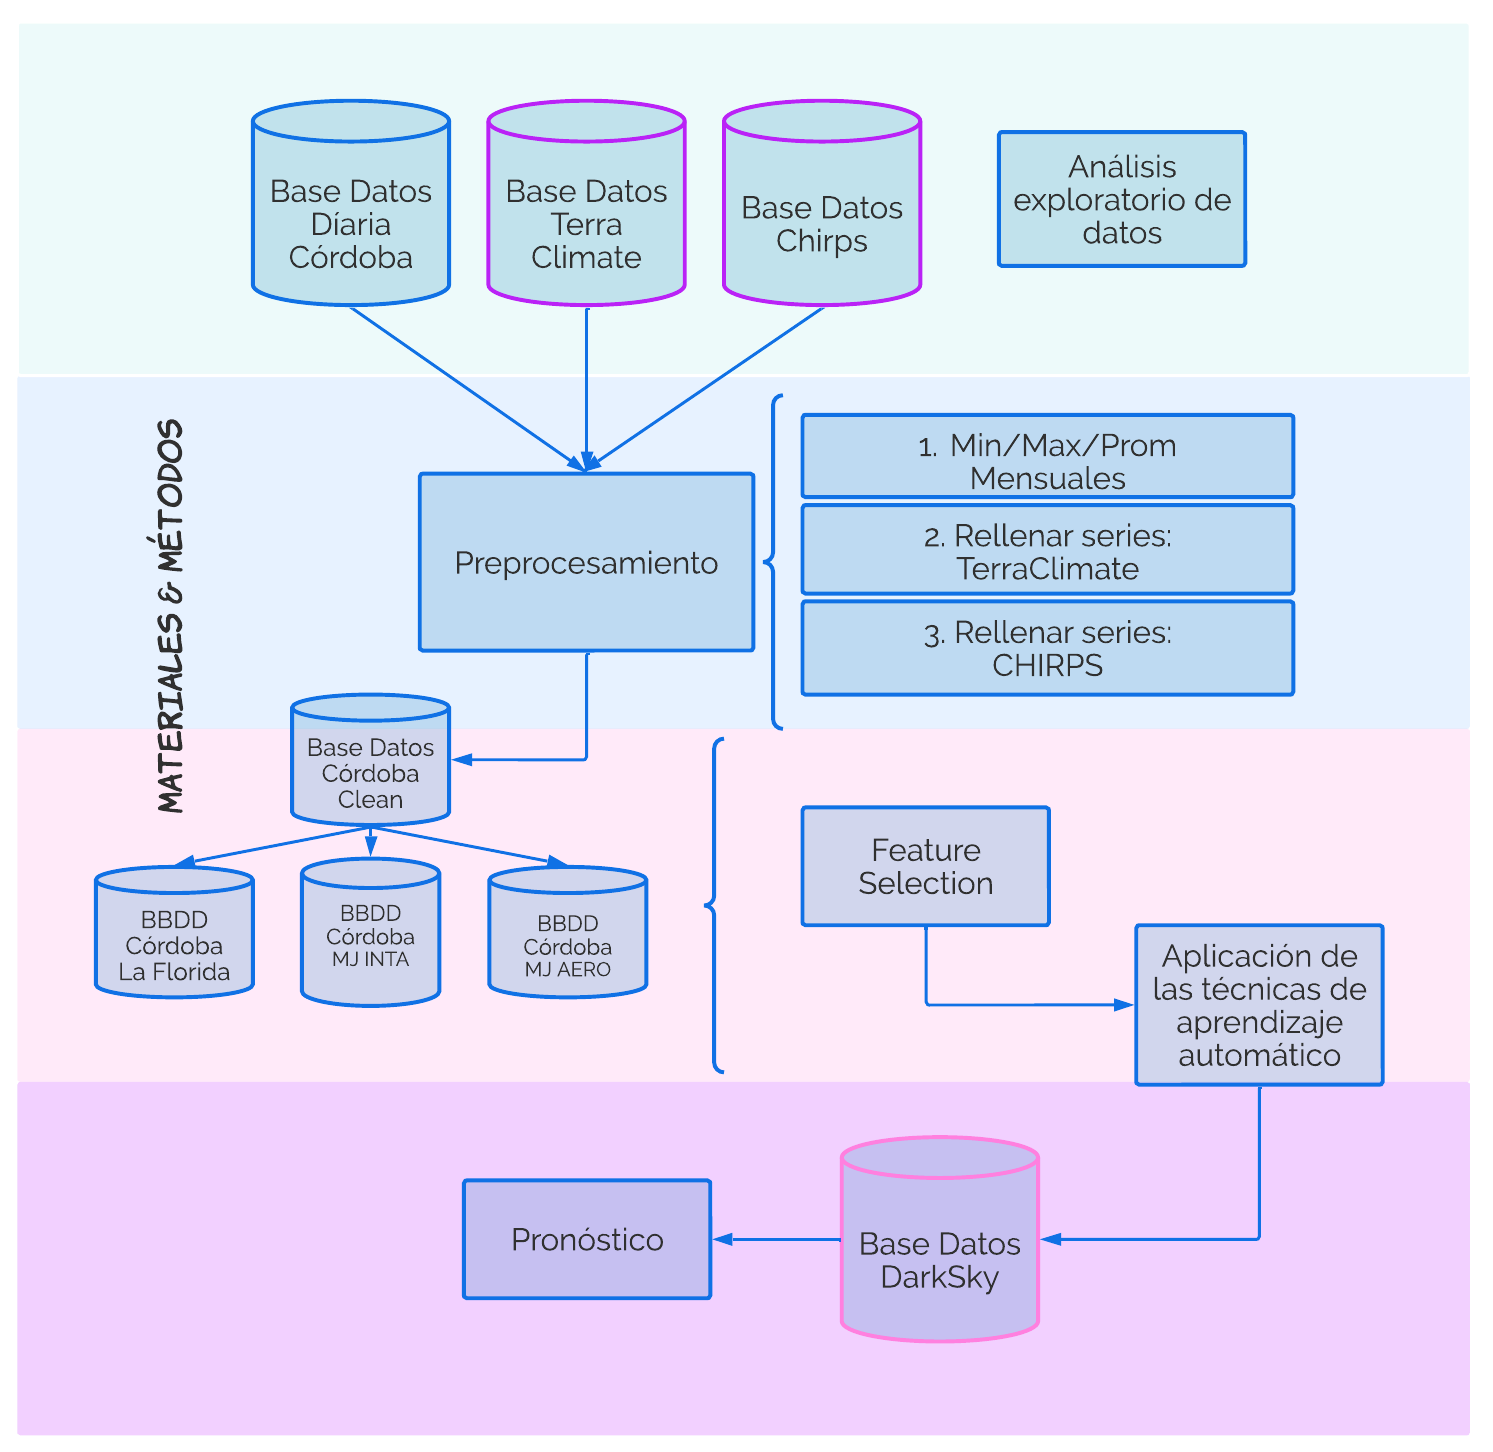

# 1)
Nota 1:
Previamente construimos algunas bases de datos correspondientes algunas curadas y sin datos ausentes: 

- Marcos Juarez - 87466 - 1967-12-31/2019-05-31 - 600 registros
(omm_id,hydro_year,Date,ETreal_mm,HumedadSuelo_mm,IndicePalmer_porc,RadSolar_Wpm2,helio,hr,hr_max/mes,hr_min/mes,prcp_PMDA,prcp_PTA,pres_est,td,tmax,tmed,tmin,vmax_f,vmed)

- Marcos Juarez - 87467 - 1967-01-31/2020-01-31 - 580 registros (omm_id,hydro_year,Date,helio,hr,hr_max/mes,hr_min/mes,nub,prcp_PMDA,prcp_PTA,pres_est,pres_nm,td,tmax,tmed,tmin,vmax_d,vmax_f,vmed)

- La Florida - 1 - 1958-01-31/2019-12-31 - 709 registros (omm_id,hydro_year,Date,ETreal_mm,HumedadSuelo_mm,IndicePalmer_porc,RadSolar_Wpm2,prcp_PMDA,prcp_PTA,pres_est,tmax,tmed,tmin,vmax_f) 

- Darksky: (omm_id,hydro_year,Date,prcp_PTA,prcp_PMDA,tmax,vmax_f,hr_max/mes,hr,pres_est,tmed,hr_min/mes,tmin)  - 2020-12-31/ para las tres estaciones...

- Una final con todos los registros pero reducida en variables en la que coincidian las tres estaciones... (omm_id,hydro_year,Date,prcp_PMDA,prcp_PTA,pres_est,tmax,tmed,tmin,vmax_f) con 2259 registros. 

## En esta notebook exploraremos los resultados de Marcos Juarez - 87466 dado que era la que mayor cantidad de variables presentaba.


      Procedimiento en Python - Imputando Datos:
          








1- Configuración de las librerías necesarías para el desarrollo del trabajo:

In [2]:
import warnings
warnings.filterwarnings("ignore")

## For data
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set_context("notebook", font_scale=1.25)

## For outliers detection
from sklearn import preprocessing, svm
## For stationarity test and decomposition
import statsmodels.tsa.api as smt
import statsmodels.api as sm

- Carga de datos todas las estaciones incluidos los datos de Marcos Juarez 87466 - Mensuales:

In [3]:
mj_87466 = pd.read_csv("https://github.com/argennof/M_Predi_Lluvias_Extremas_10\
/blob/main/BBDD_clean_tc_dc_ch/final_87466_mj.csv?raw=true", sep=';', parse_dates = True)

df = mj_87466.copy()
df.insert(0, 'id', np.arange(len(df)))
df['Date'] = pd.to_datetime(df['Date'])
df.head(3)

,id,omm_id,hydro_year,Date,ETreal_mm,HumedadSuelo_mm,IndicePalmer_porc,RadSolar_Wpm2,helio,hr,...,hr_min/mes,prcp_PMDA,prcp_PTA,pres_est,td,tmax,tmed,tmin,vmax_f,vmed
0,0,87466,1967,1967-12-31,701.0,126.0,1.94,283.8,9.76,50.94,...,39.0,17.0,66.9,18.98,14.95,39.0,23.55,8.1,3.92,3.59
1,1,87466,1967,1968-01-31,806.0,98.0,1.07,278.5,8.87,54.68,...,35.0,56.8,132.1,18.87,14.45,36.2,21.85,7.5,4.12,3.19
2,2,87466,1967,1968-02-29,775.0,81.0,-1.99,252.6,8.91,54.83,...,37.0,26.5,79.5,19.64,14.79,37.2,22.60,8.0,3.59,2.91


- Confirmamos los datos vacios que nos quedamos solo con los registros completos de PMDA y PTA

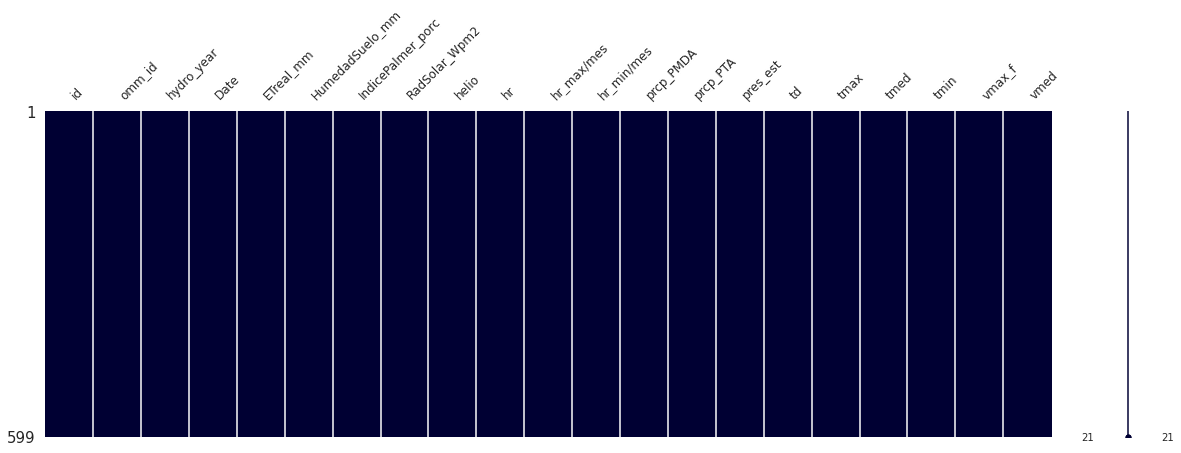

In [4]:
import missingno as msno
msno.matrix(df,figsize=(20, 6), fontsize=12, color=[0,0,0.2])



      Analisis de Series Temporales...


[Serie Temporal](https://www.kaggle.com/code/cesarg/taller-en-moldeamiento-series-de-tiempo): Conjunto de observaciones sobre los valores de una variable en diferentes momentos.

Estas presentan algunos comportamientos como:
- Tendencia: Se refiere al patrón de crecimiento o declinación.


- Estacionalidad: Se refiere a un patrón regularmente recurrente a través del tiempo (trimestres, mes o semana)


- Aleatoridad: Este comportamiento irregular está compuesto por fluctuaciones causadas por sucesos impredecibles o no periódicos.


-  Estacionaria: Es aquella serie de datos cuyas propiedades estadísticas básica, como media y la varianza, permanecen constantes en el tiempo, se dice que una serie que no presenta crecimiento o declinación es estacionaria.

- Estacionalidad: 


Determinamos si hay... para el indice de palmer y para la temperatura los datos son mensuales...
La estacionalidad es un comportamiento o patrón que a
veces observamos en una serie de tiempo. Consiste en
subidas y bajadas periódicas que se presentan en forma
regular en la serie de tiempo.
Al tiempo entre un ``pico'' y otro en una serie de datos, se
le llama período estacional.
La mayoría de las series que presentan esta característica
tienen periodicidad anual; en este caso, si la serie consiste
de observaciones mensuales, el período será 12, en
cambio, si la serie es trimestral, el período será 4.Calculo de los valores faltantes:

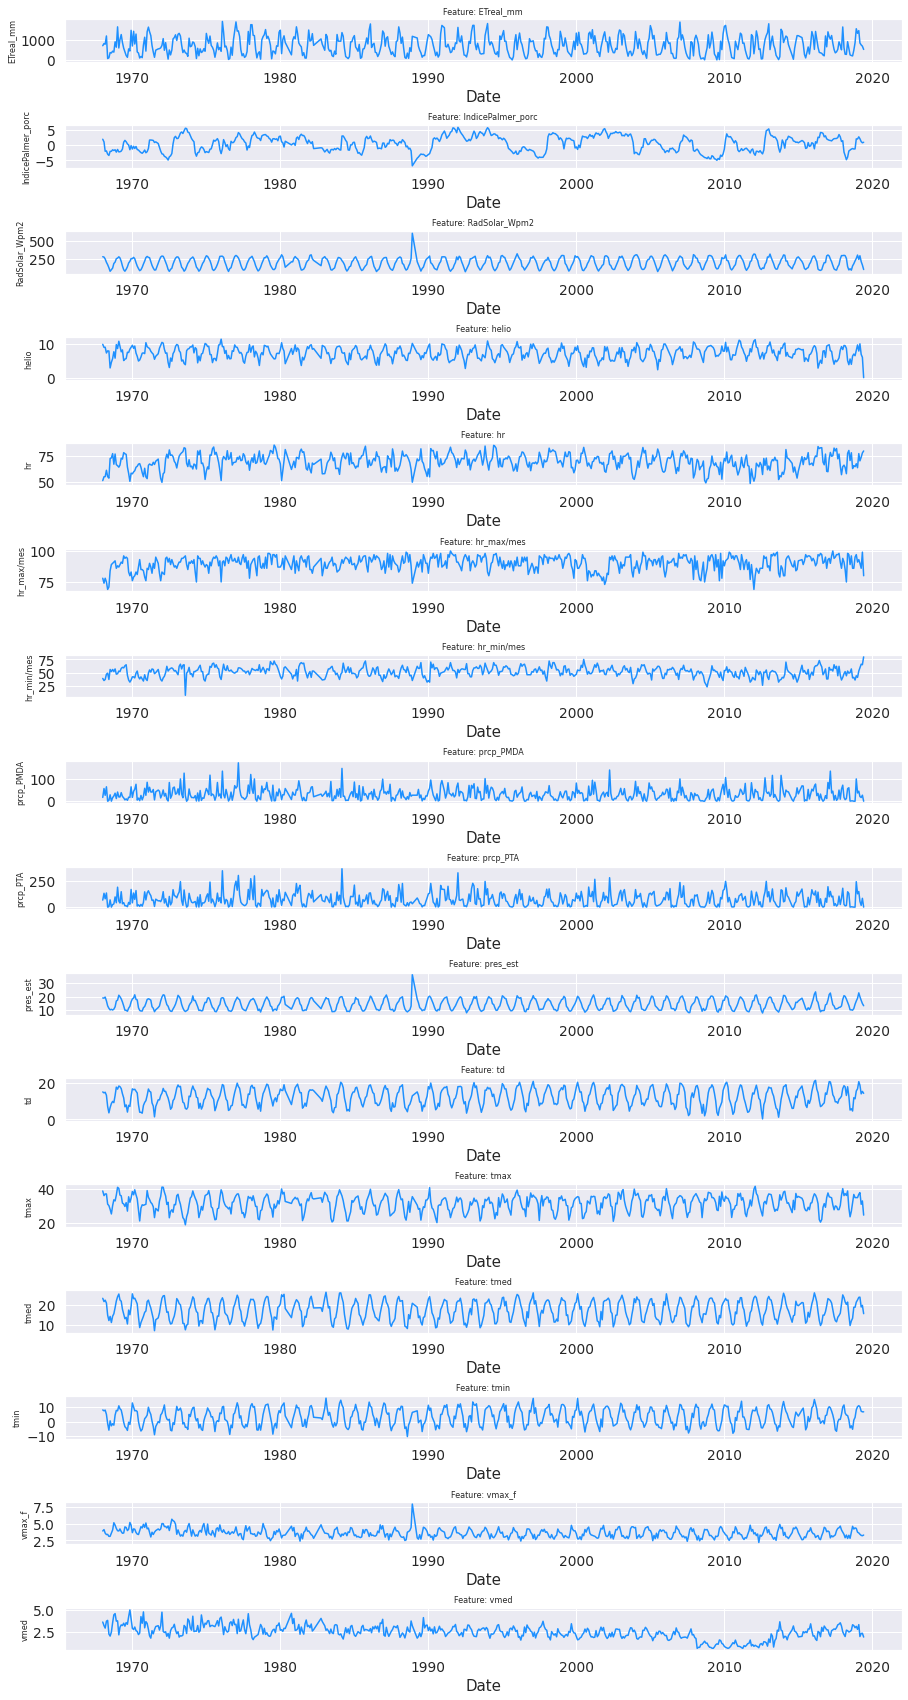

In [5]:
from datetime import datetime, date 

f, ax = plt.subplots(nrows=16, ncols=1, figsize=(15, 30))
plt.subplots_adjust(hspace=1.5)
excepto=['id','hydro_year','Date','HumedadSuelo_mm', 'omm_id','pres_est_max','pres_est_min','pres_est_prom']

for i, column in enumerate(df.columns.difference(excepto)):
    sns.lineplot(x=df['Date'], y=df[column], ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=8)
    ax[i].set_ylabel(ylabel=column, fontsize=8)
    # ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])


In [6]:
df.columns

Index(['id', 'omm_id', 'hydro_year', 'Date', 'ETreal_mm', 'HumedadSuelo_mm',
       'IndicePalmer_porc', 'RadSolar_Wpm2', 'helio', 'hr', 'hr_max/mes',
       'hr_min/mes', 'prcp_PMDA', 'prcp_PTA', 'pres_est', 'td', 'tmax', 'tmed',
       'tmin', 'vmax_f', 'vmed'],
      dtype='object')

# Umbrales indice de Palmer:
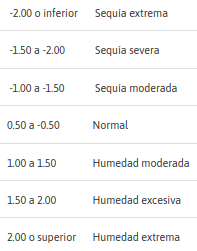

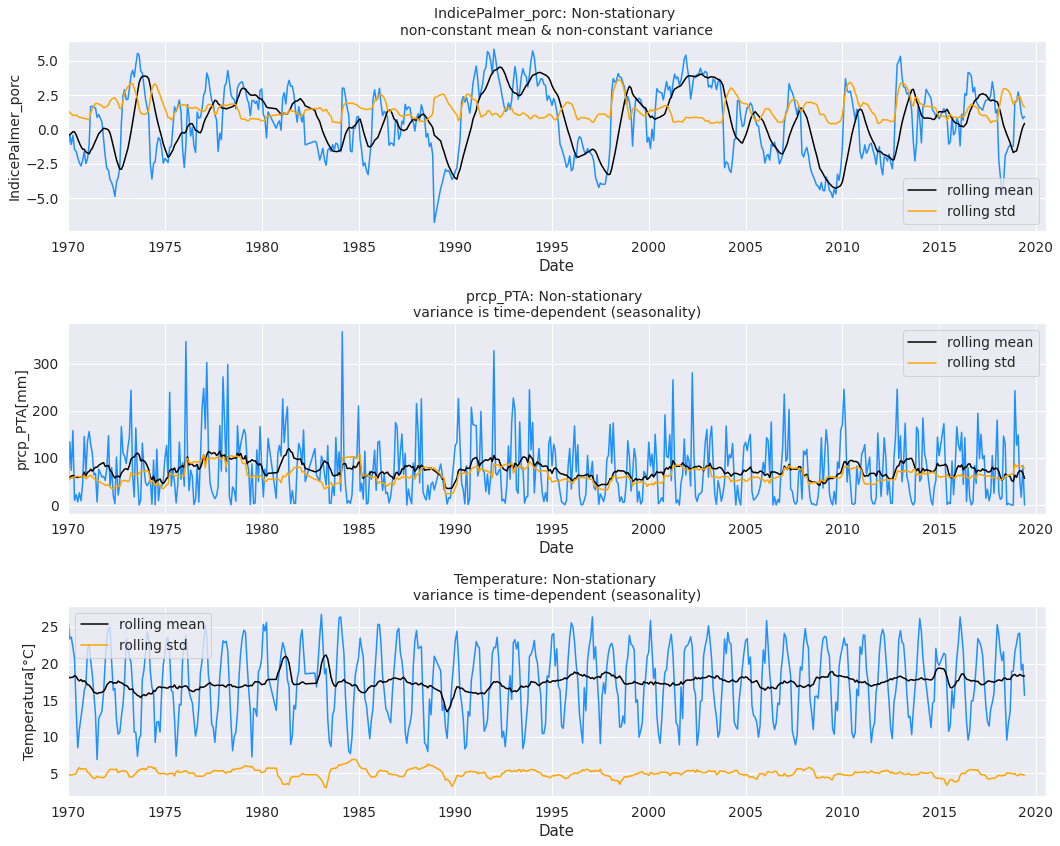

In [7]:
# A year 12 months
rolling_window = 12
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['Date'], y=df['IndicePalmer_porc'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['Date'], y=df['IndicePalmer_porc'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['Date'], y=df['IndicePalmer_porc'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('IndicePalmer_porc: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='IndicePalmer_porc', fontsize=14)
ax[0].set_xlim([date(1970, 1, 1), date(2020, 6, 30)])

sns.lineplot(x=df['Date'], y=df['prcp_PTA'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['Date'], y=df['prcp_PTA'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['Date'], y=df['prcp_PTA'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('prcp_PTA: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1].set_ylabel(ylabel='prcp_PTA[mm]', fontsize=14)
ax[1].set_xlim([date(1970, 1, 1), date(2020, 6, 30)])


sns.lineplot(x=df['Date'], y=df['tmed'], ax=ax[2], color='dodgerblue')
sns.lineplot(x=df['Date'], y=df['tmed'].rolling(rolling_window).mean(), ax=ax[2], color='black', label='rolling mean')
sns.lineplot(x=df['Date'], y=df['tmed'].rolling(rolling_window).std(), ax=ax[2], color='orange', label='rolling std')
ax[2].set_title('Temperature: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[2].set_ylabel(ylabel='Temperatura[°C]', fontsize=14)
ax[2].set_xlim([date(1970, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

In [8]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html

# La serie de Pta Acumulada es estacionaria:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['prcp_PMDA'].values)
result

adf, p, critical_value = result[0], result[1], result[4]["5%"]
p = round(p, 3)
conclusion = "Estacionaria" if p < 0.05 else "No Estacionaria"
print(conclusion)


Estacionaria


In [9]:
cols=['id', 'omm_id', 'hydro_year', 'Date', 'ETreal_mm', 'HumedadSuelo_mm',
       'IndicePalmer_porc', 'RadSolar_Wpm2', 'helio', 'hr', 'hr_max/mes',
       'hr_min/mes', 'prcp_PMDA', 'prcp_PTA', 'pres_est', 'td', 'tmax', 'tmed',
       'tmin', 'vmax_f', 'vmed']

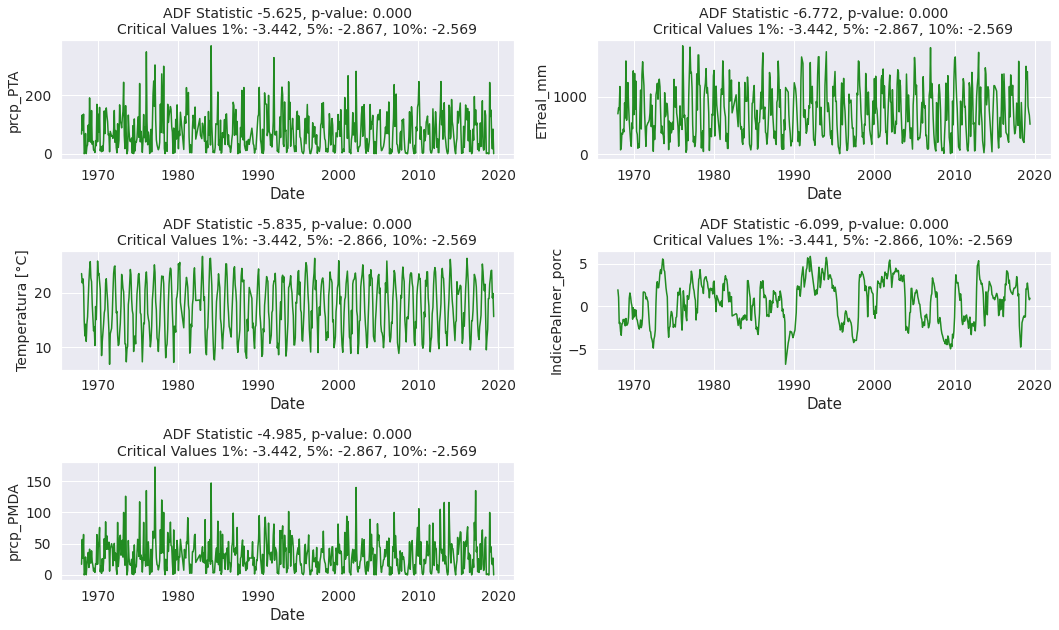

In [10]:
# Thanks to https://www.kaggle.com/iamleonie for this function!
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['Date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\n\
    Critical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df['prcp_PTA'].values, 'prcp_PTA', ax[0, 0])
visualize_adfuller_results(df['ETreal_mm'].values, 'ETreal_mm', ax[0, 1])

visualize_adfuller_results(df['tmed'].values, 'Temperatura [°C]', ax[1, 0])
visualize_adfuller_results(df['IndicePalmer_porc'].values, 'IndicePalmer_porc', ax[1, 1])

visualize_adfuller_results(df['prcp_PMDA'].values, 'prcp_PMDA', ax[2, 0])
# visualize_adfuller_results(df['RadSolar_Wpm2'].values, 'RadSolar_Wpm2', ax[2, 1])


f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

# adfuller_test = sm.tsa.stattools.adfuller(pueblo_andino_s_caudal_sum.dropna(), maxlag=5, autolag="AIC")
# adf, p, critical_value = adfuller_test[0], adfuller_test[1], adfuller_test[4]["5%"]
# p = round(p, 3)
# conclusion = "Estacionaria" if p < 0.05 else "No Estacionaria"
# print(conclusion)

En conclusion:
- Las series evaluadas son Estacionarias.

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose


# visualize_adfuller_results(df['prcp_PTA'].values, 'prcp_PTA', ax[0, 0])
# visualize_adfuller_results(df['tmed'].values, 'Temperatura [°C]', ax[1, 0])
# visualize_adfuller_results(df['ETreal_mm'].values, 'ETreal_mm', ax[0, 1])
# visualize_adfuller_results(df['IndicePalmer_porc'].values, 'IndicePalmer_porc', ax[1, 1])
# visualize_adfuller_results(df['RadSolar_Wpm2'].values, 'RadSolar_Wpm2', ax[2, 0])

core_columns =  [
    'prcp_PTA', 'tmed', 'ETreal_mm', 
    'IndicePalmer_porc', 'prcp_PMDA'
]

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=12, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

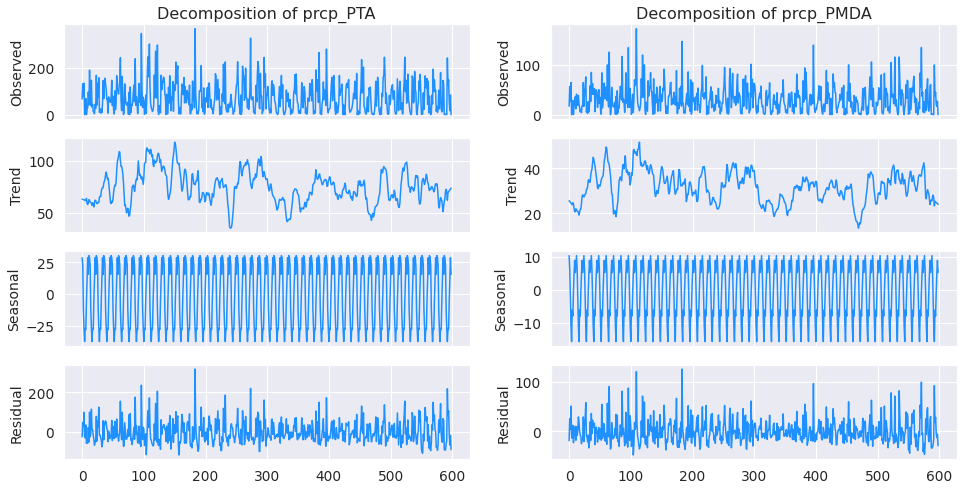

In [12]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(['prcp_PTA', 'prcp_PMDA']):
    
    res = seasonal_decompose(df[column], freq=12, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()

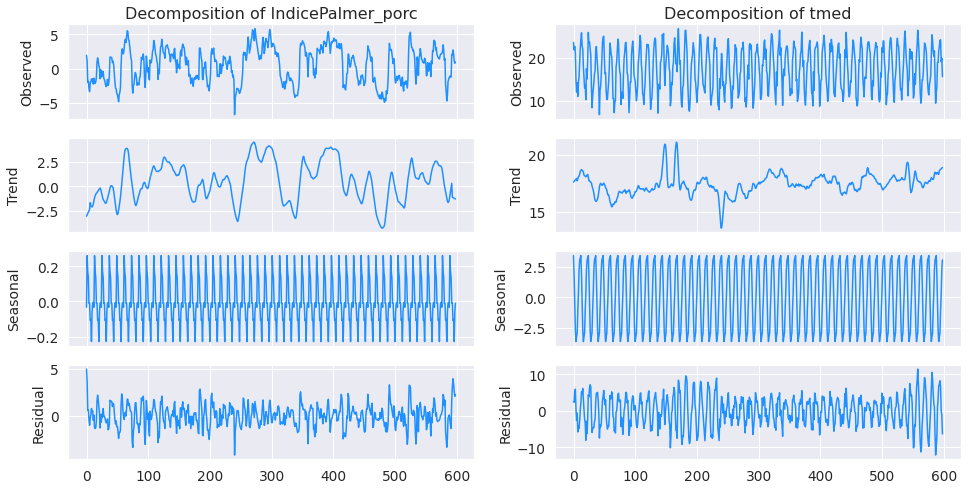

In [13]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(['IndicePalmer_porc', 'tmed']):
    
    res = seasonal_decompose(df[column], freq=12, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()

In [14]:
#weeks_in_month = 4 ### Son 4 meses???? 
month = 1 ### Son 4 meses???? 

for column in core_columns:
    df[f'{column}_seasonal_shift_b_4m'] = df[f'{column}_seasonal'].shift(-4 * month)
    df[f'{column}_seasonal_shift_b_3m'] = df[f'{column}_seasonal'].shift(-3 * month)
    df[f'{column}_seasonal_shift_b_2m'] = df[f'{column}_seasonal'].shift(-2 * month)
    df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1 * month)
    df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1 * month)
    df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2 * month)
    df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3 * month)

In [15]:
df[['Date', 'prcp_PTA','prcp_PTA_seasonal', 'prcp_PTA_seasonal_shift_b_2m', \
    'prcp_PTA_seasonal_shift_1m','prcp_PTA_seasonal_shift_2m']].head(3)

,Date,prcp_PTA,prcp_PTA_seasonal,prcp_PTA_seasonal_shift_b_2m,prcp_PTA_seasonal_shift_1m,prcp_PTA_seasonal_shift_2m
0,1967-12-31,66.9,28.598606,-11.895814,NaN,NaN
1,1968-01-31,132.1,22.630896,-26.899274,28.598606,NaN
2,1968-02-29,79.5,-11.895814,-37.423734,22.630896,28.598606


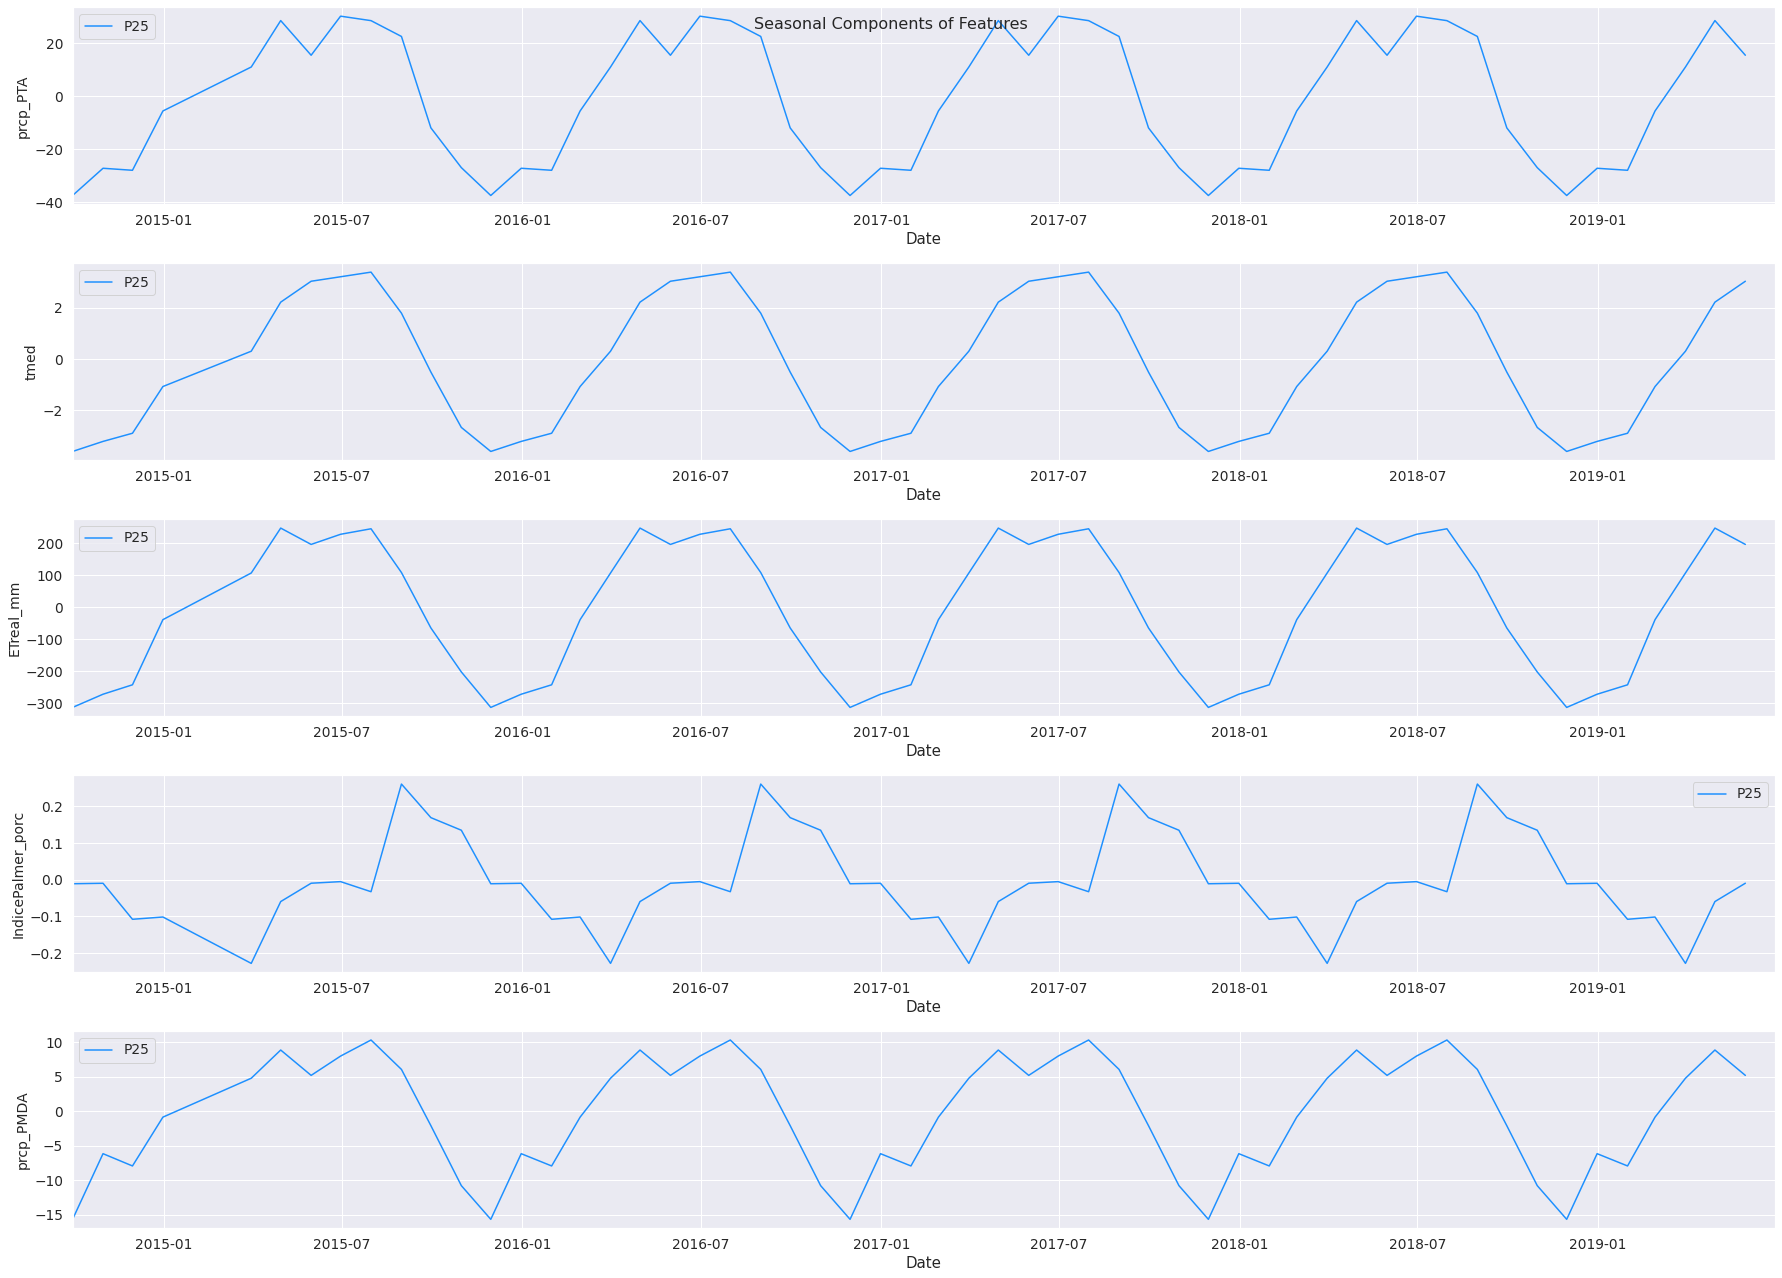

In [16]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(25, 18))
f.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(core_columns):
    # sns.lineplot(x=df['Date'], y=df[column + '_seasonal'], ax=ax[i], color='dodgerblue', label='P25')
    sns.lineplot(x=df['Date'], y=df[column + '_seasonal'], ax=ax[i], color='dodgerblue', label='P25')
    
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2014, 9, 30), date(2019, 6, 30)])
    plt.subplots_adjust(hspace=0.5)
    
plt.tight_layout()
plt.show()

https://www.kaggle.com/code/andreshg/timeseries-analysis-a-complete-guide#4.-Exploratory-Data-Analysis-%F0%9F%93%8A

In [17]:
df.columns

Index(['id', 'omm_id', 'hydro_year', 'Date', 'ETreal_mm', 'HumedadSuelo_mm',
       'IndicePalmer_porc', 'RadSolar_Wpm2', 'helio', 'hr', 'hr_max/mes',
       'hr_min/mes', 'prcp_PMDA', 'prcp_PTA', 'pres_est', 'td', 'tmax', 'tmed',
       'tmin', 'vmax_f', 'vmed', 'prcp_PTA_trend', 'prcp_PTA_seasonal',
       'tmed_trend', 'tmed_seasonal', 'ETreal_mm_trend', 'ETreal_mm_seasonal',
       'IndicePalmer_porc_trend', 'IndicePalmer_porc_seasonal',
       'prcp_PMDA_trend', 'prcp_PMDA_seasonal', 'prcp_PTA_seasonal_shift_b_4m',
       'prcp_PTA_seasonal_shift_b_3m', 'prcp_PTA_seasonal_shift_b_2m',
       'prcp_PTA_seasonal_shift_b_1m', 'prcp_PTA_seasonal_shift_1m',
       'prcp_PTA_seasonal_shift_2m', 'prcp_PTA_seasonal_shift_3m',
       'tmed_seasonal_shift_b_4m', 'tmed_seasonal_shift_b_3m',
       'tmed_seasonal_shift_b_2m', 'tmed_seasonal_shift_b_1m',
       'tmed_seasonal_shift_1m', 'tmed_seasonal_shift_2m',
       'tmed_seasonal_shift_3m', 'ETreal_mm_seasonal_shift_b_4m',
       'ETreal_m

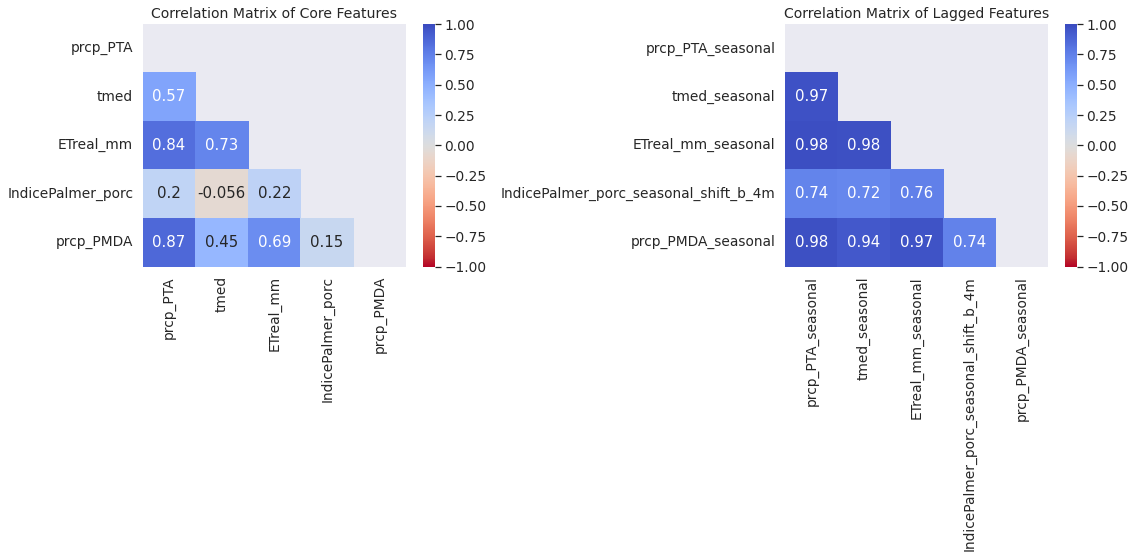

In [18]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

corrmat = df[core_columns].corr()
mtx = np.triu(corrmat)
sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0], mask=mtx)
ax[0].set_title('Correlation Matrix of Core Features', fontsize=14)

shifted_cols = [
    'prcp_PTA_seasonal',         
    'tmed_seasonal',
    'ETreal_mm_seasonal', 
    'IndicePalmer_porc_seasonal_shift_b_4m',
    'prcp_PMDA_seasonal'
]
corrmat = df[shifted_cols].corr()
mtx2 = np.triu(corrmat)
sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1], mask=mtx2)
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=14)


plt.tight_layout()
plt.show()


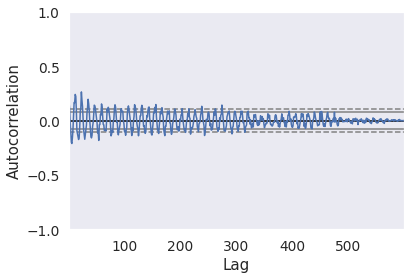

In [19]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['prcp_PMDA'])
# autocorrelation_plot(df['prcp_PMDA_seasonal'])

plt.show()

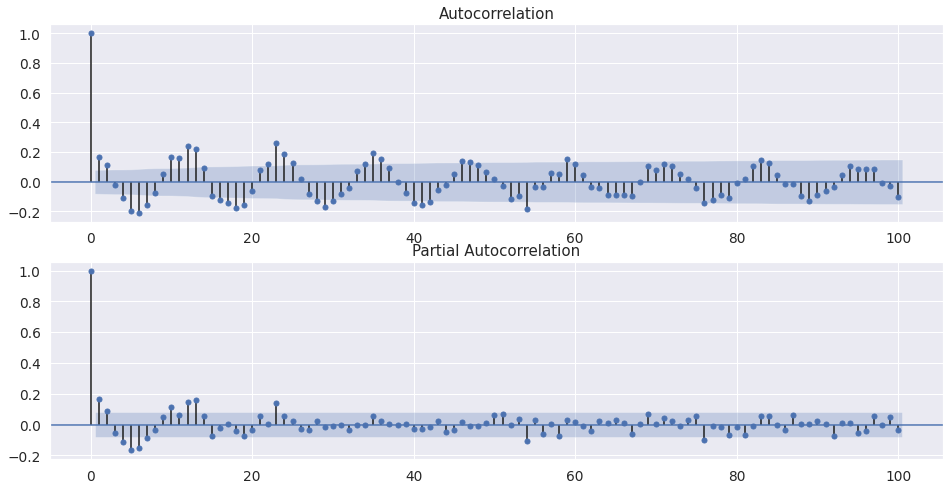

In [20]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['prcp_PMDA'], lags=100, ax=ax[0])
plot_pacf(df['prcp_PMDA'], lags=100, ax=ax[1])

plt.show()


# Modelamiento Univariado...

In [21]:
from sklearn.model_selection import TimeSeriesSplit

# split_date = '01-Jan-2015'
# pjme_train = pjme.loc[pjme.index <= split_date].copy()
# pjme_test = pjme.loc[pjme.index > split_date].copy()

# https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost#Train/Test-Split

N_SPLITS = 3

X = df['Date']
y = df['prcp_PMDA']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

In [22]:
list(folds.split(X))

[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
          13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
          26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
          39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
          52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
          65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
          78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
          91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
         104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
         117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
         130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
         143, 144, 145, 146, 147, 148, 149, 150, 151]),
  array([152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
         165, 166, 167, 168, 169, 170, 171, 172, 173, 17

0 (152,) (149,)
3:152
1 (301,) (149,)
152:301
2 (450,) (149,)
301:450


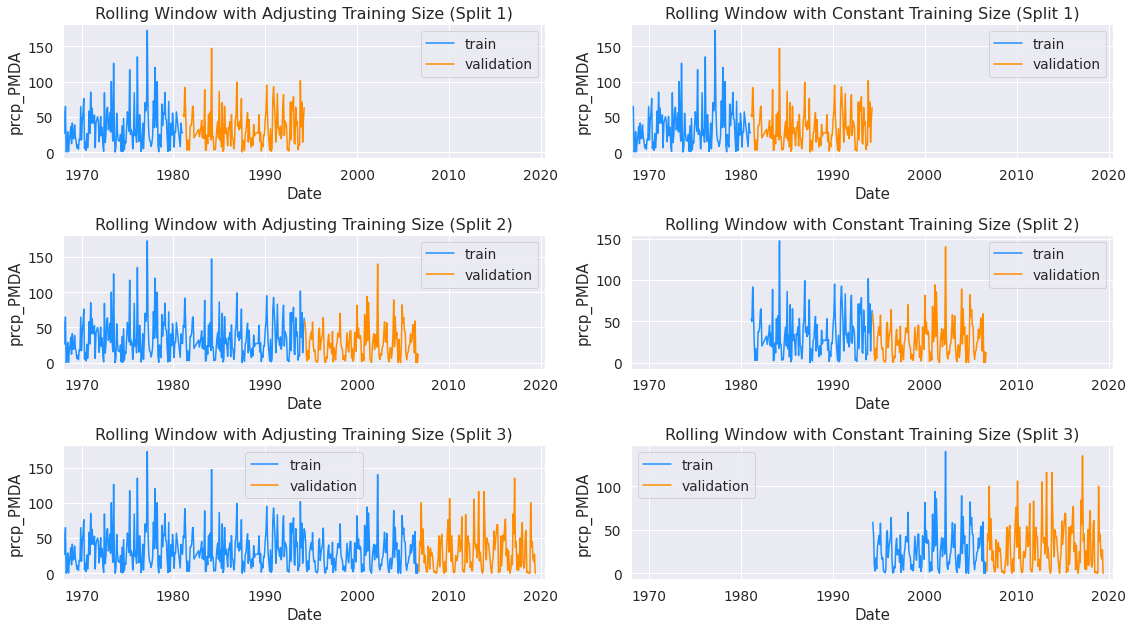

In [34]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    print(i, X_train.shape, X_valid.shape)
    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    print(f'{len(X_train) - len(X_valid)}:{len(X_train)}')
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):len(X_train)], 
        y=y_train[len(X_train) - len(X_valid):len(X_train)], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(1968, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_xlim([date(1968, 1, 1), date(2020, 6, 30)])
    
plt.tight_layout()
plt.show()

# 2) - 3) 
- Al verificar que tenemos la base de datos limpia de datos ausentes realizamos un agrupamiento por año hidrologico... con esta realizaremos el feature selection..

In [ ]:
# df.columns

In [ ]:
### Acumulado precipitación - Renombro:
datos_PTA_87466 = df[['hydro_year','omm_id','prcp_PTA']].groupby(['hydro_year', 'omm_id']).sum()

### Máximos por variable - PMDA - Renombro: 
datos_max_87466 = df[['hydro_year','omm_id','prcp_PMDA','hr_max/mes','tmax','vmax_f',\
                                   'pres_est','td']].groupby(['hydro_year', 'omm_id']).max()

datos_max_87466.rename(columns={'hr_max/mes':'hr_max','tmax':'tmax',\
                        'vmax_f':'vmax_f','pres_est':'pres_est_max',\
                        'td':'td_max'},inplace=True)                                   

### Mínimos por variable -  Renombro: 
datos_min_87466 = df[['hydro_year','omm_id','hr','tmin',
                                   'pres_est','td']].groupby(['hydro_year', 'omm_id']).min()

datos_min_87466.rename(columns={'hr':'hr_min','tmin':'tmin',\
                       'pres_est':'pres_est_min','td':'td_min'},
                     inplace=True)

                        
### Promedios por variable - Renombro: 
excepto =['id','Date','prcp_PMDA', 'prcp_PTA','tmax','vmax_d','vmax_f','hr_max/mes','hr_min/mes','tmin']
datos_prom_87466= round(df.loc[:, df. columns.difference(excepto)
                                                         ].groupby(['hydro_year', 'omm_id']).mean(),2)

datos_prom_87466.rename(columns={'ETreal_mm':'ETreal_mm_prom', 'HumedadSuelo_mm': 'HumedadSuelo_mm_prom',\
                               'IndicePalmer_porc':'IndicePalmer_porc_prom', 'RadSolar_Wpm2':'RadSolar_Wpm2_prom',\
                               'helio':'helio_prom','hr':'hr_prom','pres_est':'pres_est_prom',\
                              'td':'td_prom','tmed':'tmed','vmed':'vmed'},
                     inplace=True)


# Pegando los dataframe                     
df1= datos_PTA_87466.merge(datos_max_87466, on=['omm_id','hydro_year']) # PTA y maximos
df2 = df1.merge(datos_min_87466, on=['omm_id','hydro_year']) # PTA_maximos y minimos
d_87466 = df2.merge(datos_prom_87466, on=['omm_id','hydro_year']) # PTA_maximos_minimos_prom
d_87466.head(3) 

prcp_PTA  prcp_PMDA  hr_max  tmax  vmax_f  pres_est_max  \
omm_id hydro_year                                                            
87466  1967           418.1       64.7    78.0  39.0    4.12         19.64   
       1968           772.0       41.2    96.0  41.2    5.16         21.04   
       1969           708.6       76.0    95.0  39.7    5.20         21.35   

                   td_max  hr_min  tmin  pres_est_min  ...  ETreal_mm_prom  \
omm_id hydro_year                                      ...                   
87466  1967         14.95   50.94  -6.0         11.28  ...          607.50   
       1968         18.18   64.10  -3.0         10.00  ...          745.33   
       1969         16.64   50.23  -6.2          9.07  ...          674.25   

                   HumedadSuelo_mm_prom  IndicePalmer_porc_prom  \
omm_id hydro_year                                                 
87466  1967                       85.00                   -1.19   
       1968                      158.58                   -1.59   
       1969                      130.08                   -0.39   

                   RadSolar_Wpm2_prom  helio_prom  hr_prom  pres_est_prom  \
omm_id hydro_year                                                           
87466  1967                    220.92        8.40    54.96          16.43   
       1968                    188.09        7.08    71.08          14.67   
       1969                    189.24        7.39    63.20          14.56   

                   td_prom   tmed  vmed  
omm_id hydro_year                        
87466  1967          11.32  19.35  3.23  
       1968          13.29  18.70  3.29  
       1969          11.09  18.22  3.25  

[3 rows x 21 columns]

In [ ]:
d_87466.columns

Index(['prcp_PTA', 'prcp_PMDA', 'hr_max', 'tmax', 'vmax_f', 'pres_est_max',
       'td_max', 'hr_min', 'tmin', 'pres_est_min', 'td_min', 'ETreal_mm_prom',
       'HumedadSuelo_mm_prom', 'IndicePalmer_porc_prom', 'RadSolar_Wpm2_prom',
       'helio_prom', 'hr_prom', 'pres_est_prom', 'td_prom', 'tmed', 'vmed'],
      dtype='object')

# 4)
    Iniciaremos el procedimiento de Feature Selection.

In [ ]:
# creamos una copia del anterior
df_87466_mj = d_87466.copy()


- Visualizamos las correlaciones previamente con el fin de tener una idea de como se esta comportando el conjunto de datos en general:

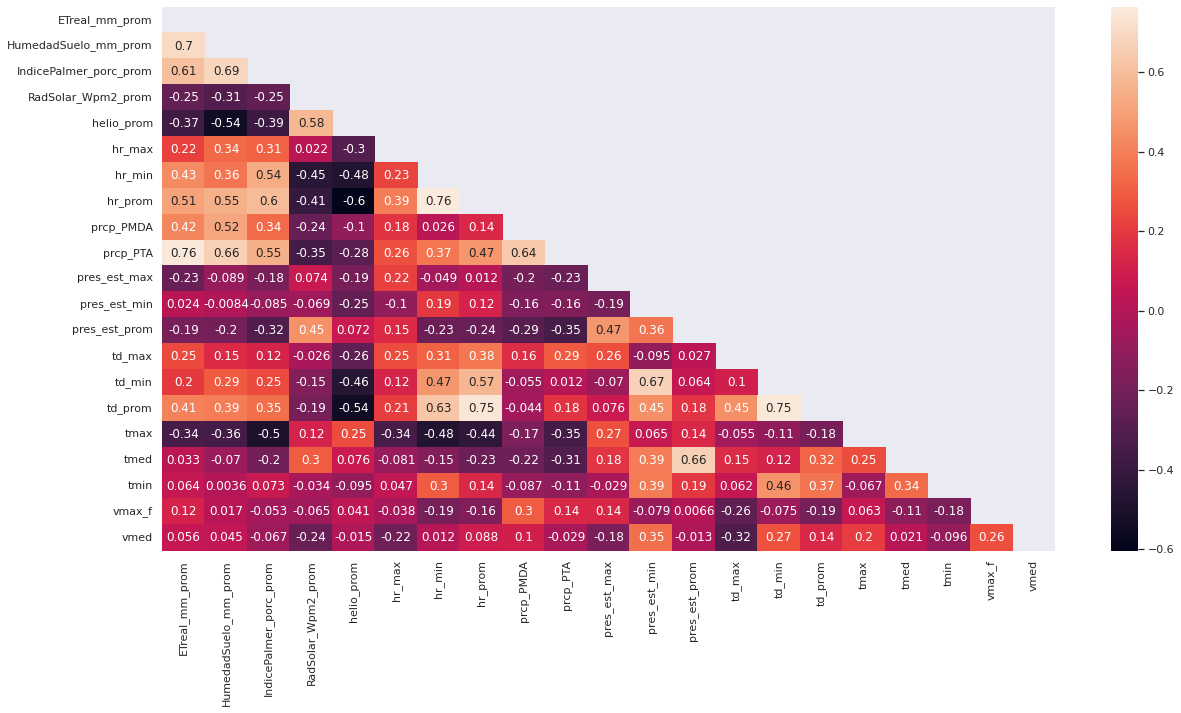

In [ ]:
df=df_87466_mj.loc[:,df_87466_mj.columns.difference(['id', 'omm_id', 'hydro_year', 'Date'])]


corr= df.corr(method='spearman')
matrix = np.triu(corr)
plt.figure(figsize=(20,10))
sns.heatmap(corr, annot=True, mask=matrix)


 Como es de esperar vemos algunas fuertes correlaciones entre la PMDA y PTA para el año hidrologico...

- Escalamos los datos:

In [ ]:
from sklearn.preprocessing import StandardScaler
excepto=['id', 'omm_id', 'hydro_year', 'Date','prcp_PMDA']
                                                        
x = df_87466_mj.loc[:,df_87466_mj.columns.difference(excepto)]
y_obs1 = df_87466_mj['prcp_PMDA'] 
# x.head(1)

# Escalado del conjunto de datos:
scaled_features = x.copy()
col_names = x.columns.tolist()
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [ ]:
# control variables:
# print(scaled_features.columns.tolist())
print(x.columns.tolist())

['ETreal_mm_prom', 'HumedadSuelo_mm_prom', 'IndicePalmer_porc_prom', 'RadSolar_Wpm2_prom', 'helio_prom', 'hr_max', 'hr_min', 'hr_prom', 'prcp_PTA', 'pres_est_max', 'pres_est_min', 'pres_est_prom', 'td_max', 'td_min', 'td_prom', 'tmax', 'tmed', 'tmin', 'vmax_f', 'vmed']


In [ ]:
# X will be a pandas dataframe of all columns excepto - > ['id', 'omm_id', 'hydro_year', 'Date','prcp_PMDA']
x = scaled_features[[col for col in scaled_features.columns]]
# Vector con valores esperados
scaled_features[col_names] = features
scaled_features.head(3)

ETreal_mm_prom  HumedadSuelo_mm_prom  \
omm_id hydro_year                                         
87466  1967             -1.133737             -1.298044   
       1968              0.287454             -0.069698   
       1969             -0.445465             -0.545477   

                   IndicePalmer_porc_prom  RadSolar_Wpm2_prom  helio_prom  \
omm_id hydro_year                                                           
87466  1967                     -0.897938            2.296085    2.480421   
       1968                     -1.110880           -1.199696   -0.244985   
       1969                     -0.472055           -1.077243    0.395073   

                     hr_max    hr_min   hr_prom  prcp_PTA  pres_est_max  \
omm_id hydro_year                                                         
87466  1967       -5.913983 -1.386256 -3.777526 -2.182856     -0.380193   
       1968       -0.087153  1.100683  0.477457 -0.433750      0.191431   
       1969       -0.410866 -1.520430 -1.602522 -0.747097      0.318005   

                   pres_est_min  pres_est_prom    td_max    td_min   td_prom  \
omm_id hydro_year                                                              
87466  1967            2.824825       3.985852 -2.797641 -0.769603 -1.008070   
       1968            1.062355       0.595025 -0.378885  0.691032  1.068895   
       1969           -0.218190       0.383098 -1.532100 -0.549997 -1.250559   

                       tmax      tmed      tmin    vmax_f      vmed  
omm_id hydro_year                                                    
87466  1967        0.538357  2.007127 -0.197893 -0.994480  1.290198  
       1968        1.727315  1.307520  1.330388  0.865183  1.394240  
       1969        0.916662  0.790887 -0.299778  0.936709  1.324878

In [ ]:
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression


from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest

from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

In [ ]:
def result_iteracion(features,scores,color,metodo,criterio):

  sns.set(style=color)
  x = features.columns.tolist()
  y = scores
  
  pairs = zip(x, y)
  pairs= sorted(pairs, key=lambda x: x[1], reverse= True)
  plt.xticks(rotation=90)
    
  newx, newy = zip(*pairs)
  
  ax = sns.barplot(x=list(newx), y=list(newy))
  ax.set_title(f'{metodo}',  fontsize = 12)
  plt.ylabel(f'{criterio} Feature Scores')
  plt.show()


  # Almacenando los reportes:
 
  for newx, newy in pairs:
    print(f'score: {newy:0.2f} - var: {newx}')


In [ ]:
# Feature selection
KB_fs = SelectKBest(score_func = f_regression, k="all").fit(x, y_obs1)
scores_fr =  KB_fs.scores_


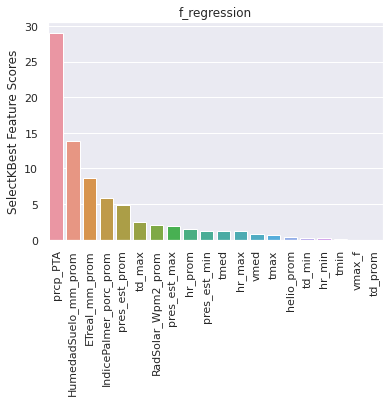

score: 29.06 - var: prcp_PTA
score: 13.91 - var: HumedadSuelo_mm_prom
score: 8.66 - var: ETreal_mm_prom
score: 5.90 - var: IndicePalmer_porc_prom
score: 4.82 - var: pres_est_prom
score: 2.43 - var: td_max
score: 2.10 - var: RadSolar_Wpm2_prom
score: 1.87 - var: pres_est_max
score: 1.48 - var: hr_prom
score: 1.27 - var: pres_est_min
score: 1.22 - var: tmed
score: 1.16 - var: hr_max
score: 0.80 - var: vmed
score: 0.68 - var: tmax
score: 0.39 - var: helio_prom
score: 0.28 - var: td_min
score: 0.27 - var: hr_min
score: 0.07 - var: tmin
score: 0.01 - var: vmax_f
score: 0.00 - var: td_prom


In [ ]:
#show_results(x, scores)
# Aplicando la funcion 
result_iteracion(x,scores_fr,color = "darkgrid", metodo = 'f_regression', criterio ='SelectKBest')

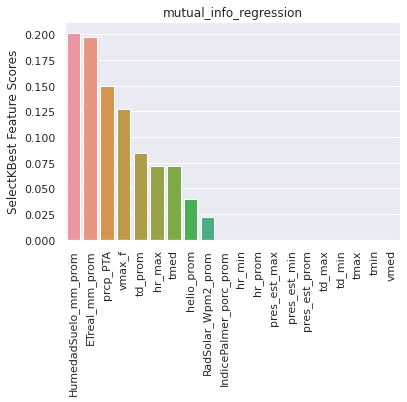

score: 0.20 - var: HumedadSuelo_mm_prom
score: 0.20 - var: ETreal_mm_prom
score: 0.15 - var: prcp_PTA
score: 0.13 - var: vmax_f
score: 0.08 - var: td_prom
score: 0.07 - var: hr_max
score: 0.07 - var: tmed
score: 0.04 - var: helio_prom
score: 0.02 - var: RadSolar_Wpm2_prom
score: 0.00 - var: IndicePalmer_porc_prom
score: 0.00 - var: hr_min
score: 0.00 - var: hr_prom
score: 0.00 - var: pres_est_max
score: 0.00 - var: pres_est_min
score: 0.00 - var: pres_est_prom
score: 0.00 - var: td_max
score: 0.00 - var: td_min
score: 0.00 - var: tmax
score: 0.00 - var: tmin
score: 0.00 - var: vmed


In [ ]:
# los métodos de información mutua pueden capturar cualquier tipo de dependencia estadística, 
# pero al no ser paramétricos, requieren más muestras para una estimación precisa.

KB_fs_mr  = SelectKBest(score_func=mutual_info_regression, k="all").fit(x, y_obs1)
scores_mr =  KB_fs_mr .scores_
# Aplicando la funcion 

result_iteracion(x,scores_mr,color = "darkgrid", metodo = 'mutual_info_regression', criterio ='SelectKBest')

# Dados los puntajes anteriores - seleccionamos las siguientes variables para predecir la PMDA:
- score: 0.20 - var: HumedadSuelo_mm_prom
- score: 0.20 - var: ETreal_mm_prom
- score: 0.15 - var: prcp_PTA
- score: 0.13 - var: vmax_f
- score: 0.08 - var: td_prom
- score: 0.07 - var: hr_max
- score: 0.07 - var: tmed
- score: 0.04 - var: helio_prom



# 5)

- División del conjunto de datos:

In [ ]:
# from sklearn.model_selection import train_test_split
# X, y = boston['data'], boston['target']
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
# X_train.shape, X_test.shape

Aca inicia:
- https://towardsdatascience.com/time-series-analysis-for-machine-learning-with-python-626bee0d0205

- https://github.com/mdipietro09/DataScience_ArtificialIntelligence_Utils/blob/master/time_series/example_forecast.ipynb


Busqueda en internet:

https://towardsdatascience.com/predicting-rain-with-machine-learning-2acf80017c44

https://www.kaggle.com/code/nasirmeh/prediction-of-rainfall

https://www.kaggle.com/code/fahadmehfoooz/rain-prediction-with-90-65-accuracy

https://www.kaggle.com/code/chandrimad31/rainfall-prediction-7-popular-models